<a href="https://colab.research.google.com/github/cl9612023/Journals-Paper/blob/main/Aberration_predict(interference_).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
%tensorflow_version 1.x
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Input, Conv2D, MaxPooling2D, Activation,concatenate
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.layers.convolutional import  AveragePooling2D
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import gc
from math import pi
import random

#Google Cloud permissions
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
#(x,y) to (r,theta)
def cart2pol(x,y):
    rho = np.sqrt(x**2+y**2)
    phi = np.arctan2(y,x)
    return(rho,phi)

In [11]:
#定議Zernike的32階係數的名稱a1-a32
column_names = []
for i in range(0,32,1):
  i = str(i+1)
  a = 'a'+i
  column_names.append(a)
print(column_names)

['a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a7', 'a8', 'a9', 'a10', 'a11', 'a12', 'a13', 'a14', 'a15', 'a16', 'a17', 'a18', 'a19', 'a20', 'a21', 'a22', 'a23', 'a24', 'a25', 'a26', 'a27', 'a28', 'a29', 'a30', 'a31', 'a32']


In [12]:
#產生相位資訊，輸入為半徑、角度和隨機係數
def phase(rho,theta,c):
    phi =c[0,0]*1 \
            +c[0,1]* 2 * rho * np.sin(theta) \
            +c[0,2]* 2 * rho * np.cos(theta)\
            +c[0,3]*np.sqrt(6)*rho**2 * np.sin(2*theta)\
            +c[0,4]*np.sqrt(3)*(2*rho**2 - 1)\
            +c[0,5]*np.sqrt(6)*rho**2 * np.cos(2*theta)\
            +c[0,6]*np.sqrt(8)*rho**3 * np.sin(3*theta)\
            +c[0,7]*np.sqrt(8)*(3*rho**3 - 2*rho) * np.sin(theta)\
            +c[0,8]*np.sqrt(8)*(3*rho**3 - 2*rho) * np.cos(theta)\
            +c[0,9]*np.sqrt(8)*rho**3 * np.cos(3*theta)\
            +c[0,10]*np.sqrt(10)*rho**4* np.sin(4*theta)\
            +c[0,11]*np.sqrt(10)*(4*rho**4 - 3*rho**2) * np.sin(2*theta)\
            +c[0,12]*np.sqrt(5)*(6*rho**4 - 6*rho**2 + 1)\
            +c[0,13]*np.sqrt(10)*(4*rho**4 - 3*rho**2) * np.cos(2*theta)\
            +c[0,14]*np.sqrt(10)*rho**4* np.cos(4*theta)\
            +c[0,15]*np.sqrt(12)*rho**5* np.sin(5*theta)\
            +c[0,16]*np.sqrt(12)*(5*rho**5 - 4*rho**3) * np.sin(3*theta)\
            +c[0,17]*np.sqrt(12)*(10*rho**5 - 12*rho**3 + 3*rho) * np.sin(theta)\
            +c[0,18]*np.sqrt(12)*(10*rho**5 - 12*rho**3 + 3*rho) * np.cos(theta)\
            +c[0,19]*np.sqrt(12)*(5*rho**5 - 4*rho**3) * np.cos(3*theta)\
            +c[0,20]*np.sqrt(12)*rho**5* np.cos(5*theta)\
            +c[0,21]*np.sqrt(14)*rho**6* np.sin(6*theta)\
            +c[0,22]*np.sqrt(14)*(6*rho**6 - 5*rho**4) * np.sin(4*theta)\
            +c[0,23]*np.sqrt(14)*(15*rho**6 - 20*rho**4 + 6*rho**2) * np.sin(2*theta)\
            +c[0,24]*np.sqrt(7)*(20*rho**6 - 30*rho**4 + 12*rho**2 - 1)\
            +c[0,25]*np.sqrt(14)*(15*rho**6 - 20*rho**4 + 6*rho**2) * np.cos(2*theta)\
            +c[0,26]*np.sqrt(14)*(6*rho**6 - 5*rho**4) * np.cos(4*theta)\
            +c[0,27]*np.sqrt(14)*rho**6* np.cos(6*theta)\
            +c[0,28]*4 * rho**7* np.sin(7*theta)\
            +c[0,29]*4 *(7*rho**7 - 6*rho**5) * np.sin(5*theta)\
            +c[0,30]*4 *(21*rho**7 - 30*rho**5 + 10*rho**3) * np.sin(3*theta)\
            +c[0,31]*4 *(35*rho**7 - 60*rho**5 + 30*rho**3 - 4*rho) * np.sin(theta)
    return phi

In [13]:
#GoogleNet架構
def Conv2d_BN(x, nb_filter, kernel_size, padding='same', strides=(1, 1)):
    x = Conv2D(nb_filter, kernel_size, padding=padding, strides=strides, activation='tanh')(x)
    return x
def Inception(x, nb_filter):
    branch1x1 = Conv2d_BN(x, nb_filter, (1, 1), padding='same', strides=(1, 1))

    branch3x3 = Conv2d_BN(x, nb_filter, (1, 1), padding='same', strides=(1, 1))
    branch3x3 = Conv2d_BN(branch3x3, nb_filter, (1, 3), padding='same', strides=(1, 1))
    branch3x3 = Conv2d_BN(branch3x3, nb_filter, (3, 1), padding='same', strides=(1, 1))

    branch5x5 = Conv2d_BN(x, nb_filter, (1, 1), padding='same', strides=(1, 1))
    branch5x5 = Conv2d_BN(branch3x3, nb_filter, (1, 3), padding='same', strides=(1, 1))
    branch5x5 = Conv2d_BN(branch3x3, nb_filter, (3, 1), padding='same', strides=(1, 1))
    branch5x5 = Conv2d_BN(branch3x3, nb_filter, (1, 3), padding='same', strides=(1, 1))
    branch3x3 = Conv2d_BN(branch3x3, nb_filter, (3, 1), padding='same', strides=(1, 1))

    branchpool = MaxPooling2D(pool_size=(3, 3), strides=(1, 1), padding='same')(x)
    branchpool = Conv2d_BN(branchpool, nb_filter, (1, 1), padding='same', strides=(1, 1))

    x = concatenate([branch1x1, branch3x3, branch5x5, branchpool], axis=3)

    return x

inpt = Input(shape=(256, 256, 1))    
x = Conv2d_BN(inpt,64, (7, 7),  strides=(2, 2), padding='same')
x  = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)
x  = Conv2d_BN(x, 192, (3, 3), strides=(1, 1), padding='same')
x  = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)
x  = Inception(x, 64)  
x  = Inception(x, 120)  
x  = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)
x  = Inception(x, 128)  
x  = Inception(x, 128)
x  = Inception(x, 128)
x  = Inception(x, 132)  
x  = Inception(x, 208)  
x  = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)
x  = Inception(x, 208)
x  = Inception(x, 256)  
x  = AveragePooling2D(pool_size=(7, 7), strides=(7, 7), padding='same')(x)
x = Flatten()(x)
x = Dense(2048, activation='tanh')(x)
x = Dense(1024, activation='tanh')(x)
x = Dense(1024, activation='tanh')(x)
x = Dense(32, activation='linear')(x)
model = Model(inpt, x, name='inception')

#loss function、優化器選擇
model.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam(lr=0.00001), metrics=['accuracy'])
model.summary()

Model: "inception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_93 (Conv2D)              (None, 128, 128, 64) 3200        input_2[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_14 (MaxPooling2D) (None, 64, 64, 64)   0           conv2d_93[0][0]                  
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 64, 64, 192)  110784      max_pooling2d_14[0][0]           
__________________________________________________________________________________________

In [14]:
#產生驗證數據
num =500
a = np.linspace(-128, 127, 256)
xv,yv = np.meshgrid( a , a )
yv = yv*-1
rho,theta = cart2pol( xv , yv )
m =rho.max()*0.7
rho = rho/m
rho[rho>1]=np.nan
COE = np.zeros([num,32])
Y = np.zeros((num, 256, 256))
for i in tqdm(range(0,num,1)):
    c =np.random.rand(1,32)-0.5
    if abs(c [0,0]) < 0.1:
        c[0,0] = c[0,0]*10
    c = c.round(6)
    COE[i,:]=c
    phi=phase(rho,theta,c)
    fring = 4 * np.cos(phi*2*pi/2)**2
    fring2 = 4 * np.cos((phi*2*pi/2)+(pi/4))**2
    fring3 =fring / fring2
    fring3[np.isnan(fring3)] = 0
    Y[i] = fring3
raw = pd.DataFrame(COE,columns=column_names)
Y=Y.reshape(num, 256, 256,1)
X_test, y_test = Y , raw

#設定訓練數據
def train_batch_generator(ran):
    a = np.linspace(-128, 127, 256)
    xv,yv = np.meshgrid( a , a )
    yv = yv*-1
    rho,theta = cart2pol( xv , yv )
    m =rho.max()*0.7
    rho = rho/m
    rho[rho>1]=np.nan
    z = np.zeros([ran,32])
    X = np.zeros((ran, 256, 256))
    for i in tqdm(range(0,ran,1)):
        c =np.random.rand(1,32)-0.5
        if abs(c [0,0]) < -0.1:
            c[0,0] = c[0,0]*10
        c = c.round(6)
        z[i,:]=c
        phi=phase(rho,theta,c)
        fring = 4 * np.cos(phi*2*pi/2)**2
        fring2 = 4 * np.cos((phi*2*pi/2)+(pi/4))**2
        fring3 =fring / fring2
        fring3[np.isnan(fring3)] = 0
        X[i] = fring3
    raw_dataset = pd.DataFrame(z,columns=column_names)
    X=X.reshape(ran, 256, 256,1)
    X_train, y_train = X , raw_dataset
    del X
    gc.collect()
    yield (X_train, y_train)

In [15]:
#訓練過程
weight_saver = ModelCheckpoint('/content/drive/My Drive/Masterpiece/modle/finalfringe(test).h5', monitor='val_loss', save_best_only=True,verbose=2)
earlystop = EarlyStopping(monitor='accuracy', patience=30,verbose=2)
rle = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=20,verbose=1,min_lr=1e-15)
NUM_EPOCHS = 10
history_all = {}
for i in range(NUM_EPOCHS):
    print('################{0} epochs#############'.format(i+1))
    for X_train, y_train in train_batch_generator(1000):
      history = model.fit(X_train, y_train,
                  validation_data=(X_test, y_test),
                  epochs= 20, batch_size=32,verbose=2,callbacks = [weight_saver,earlystop,rle])
      if len(history_all) == 0:
        history_all = {key: [] for key in history.history}
      for key in history_all:
        history_all[key].extend(history.history[key])

################1 epochs#############



Train on 1000 samples, validate on 500 samples
Epoch 1/20
 - 11s - loss: 0.0971 - accuracy: 0.0320 - val_loss: 0.0925 - val_accuracy: 0.0440

Epoch 00001: val_loss improved from inf to 0.09255, saving model to /content/drive/My Drive/Masterpiece/modle/finalfringe(test).h5
Epoch 2/20
 - 6s - loss: 0.0875 - accuracy: 0.0400 - val_loss: 0.0911 - val_accuracy: 0.0280

Epoch 00002: val_loss improved from 0.09255 to 0.09113, saving model to /content/drive/My Drive/Masterpiece/modle/finalfringe(test).h5
Epoch 3/20
 - 6s - loss: 0.0863 - accuracy: 0.0420 - val_loss: 0.0900 - val_accuracy: 0.0300

Epoch 00003: val_loss improved from 0.09113 to 0.09002, saving model to /content/drive/My Drive/Masterpiece/modle/finalfringe(test).h5
Epoch 4/20
 - 6s - loss: 0.0865 - accuracy: 0.0340 - val_loss: 0.0921 - val_accuracy: 0.0260

Epoch 00004: val_loss did not improve from 0.09002
Epoch 5/20
 - 6s - loss: 0.0858 - accuracy: 0.0280 - val_loss: 0.0888 - val_accuracy: 0.0340

Epoch 00005: val_loss improve


Train on 1000 samples, validate on 500 samples
Epoch 1/20
 - 6s - loss: 0.0867 - accuracy: 0.0420 - val_loss: 0.0897 - val_accuracy: 0.0360

Epoch 00001: val_loss did not improve from 0.08881
Epoch 2/20
 - 6s - loss: 0.0847 - accuracy: 0.0390 - val_loss: 0.0891 - val_accuracy: 0.0220

Epoch 00002: val_loss did not improve from 0.08881
Epoch 3/20
 - 6s - loss: 0.0833 - accuracy: 0.0600 - val_loss: 0.0893 - val_accuracy: 0.0400

Epoch 00003: val_loss did not improve from 0.08881
Epoch 4/20
 - 6s - loss: 0.0817 - accuracy: 0.0480 - val_loss: 0.0890 - val_accuracy: 0.0520

Epoch 00004: val_loss did not improve from 0.08881
Epoch 5/20
 - 6s - loss: 0.0800 - accuracy: 0.0600 - val_loss: 0.0879 - val_accuracy: 0.0300

Epoch 00005: val_loss improved from 0.08881 to 0.08787, saving model to /content/drive/My Drive/Masterpiece/modle/finalfringe(test).h5
Epoch 6/20
 - 6s - loss: 0.0774 - accuracy: 0.0630 - val_loss: 0.0869 - val_accuracy: 0.0600

Epoch 00006: val_loss improved from 0.08787 to 0.


Train on 1000 samples, validate on 500 samples
Epoch 1/20
 - 6s - loss: 0.0687 - accuracy: 0.1250 - val_loss: 0.0718 - val_accuracy: 0.1420

Epoch 00001: val_loss improved from 0.07262 to 0.07178, saving model to /content/drive/My Drive/Masterpiece/modle/finalfringe(test).h5
Epoch 2/20
 - 6s - loss: 0.0643 - accuracy: 0.1240 - val_loss: 0.0688 - val_accuracy: 0.1320

Epoch 00002: val_loss improved from 0.07178 to 0.06884, saving model to /content/drive/My Drive/Masterpiece/modle/finalfringe(test).h5
Epoch 3/20
 - 6s - loss: 0.0603 - accuracy: 0.1410 - val_loss: 0.0674 - val_accuracy: 0.1220

Epoch 00003: val_loss improved from 0.06884 to 0.06743, saving model to /content/drive/My Drive/Masterpiece/modle/finalfringe(test).h5
Epoch 4/20
 - 6s - loss: 0.0568 - accuracy: 0.1480 - val_loss: 0.0668 - val_accuracy: 0.1420

Epoch 00004: val_loss improved from 0.06743 to 0.06681, saving model to /content/drive/My Drive/Masterpiece/modle/finalfringe(test).h5
Epoch 5/20
 - 6s - loss: 0.0546 - ac


Train on 1000 samples, validate on 500 samples
Epoch 1/20
 - 6s - loss: 0.0539 - accuracy: 0.1660 - val_loss: 0.0552 - val_accuracy: 0.1500

Epoch 00001: val_loss improved from 0.05655 to 0.05522, saving model to /content/drive/My Drive/Masterpiece/modle/finalfringe(test).h5
Epoch 2/20
 - 6s - loss: 0.0499 - accuracy: 0.1680 - val_loss: 0.0551 - val_accuracy: 0.1560

Epoch 00002: val_loss improved from 0.05522 to 0.05510, saving model to /content/drive/My Drive/Masterpiece/modle/finalfringe(test).h5
Epoch 3/20
 - 6s - loss: 0.0458 - accuracy: 0.1730 - val_loss: 0.0539 - val_accuracy: 0.1680

Epoch 00003: val_loss improved from 0.05510 to 0.05387, saving model to /content/drive/My Drive/Masterpiece/modle/finalfringe(test).h5
Epoch 4/20
 - 6s - loss: 0.0436 - accuracy: 0.1790 - val_loss: 0.0533 - val_accuracy: 0.1700

Epoch 00004: val_loss improved from 0.05387 to 0.05334, saving model to /content/drive/My Drive/Masterpiece/modle/finalfringe(test).h5
Epoch 5/20
 - 6s - loss: 0.0409 - ac


Train on 1000 samples, validate on 500 samples
Epoch 1/20
 - 6s - loss: 0.0453 - accuracy: 0.2010 - val_loss: 0.0469 - val_accuracy: 0.1900

Epoch 00001: val_loss improved from 0.04747 to 0.04688, saving model to /content/drive/My Drive/Masterpiece/modle/finalfringe(test).h5
Epoch 2/20
 - 6s - loss: 0.0409 - accuracy: 0.1930 - val_loss: 0.0460 - val_accuracy: 0.2120

Epoch 00002: val_loss improved from 0.04688 to 0.04600, saving model to /content/drive/My Drive/Masterpiece/modle/finalfringe(test).h5
Epoch 3/20
 - 6s - loss: 0.0384 - accuracy: 0.1990 - val_loss: 0.0455 - val_accuracy: 0.1680

Epoch 00003: val_loss improved from 0.04600 to 0.04549, saving model to /content/drive/My Drive/Masterpiece/modle/finalfringe(test).h5
Epoch 4/20
 - 6s - loss: 0.0351 - accuracy: 0.2130 - val_loss: 0.0444 - val_accuracy: 0.2060

Epoch 00004: val_loss improved from 0.04549 to 0.04444, saving model to /content/drive/My Drive/Masterpiece/modle/finalfringe(test).h5
Epoch 5/20
 - 6s - loss: 0.0331 - ac


Train on 1000 samples, validate on 500 samples
Epoch 1/20
 - 6s - loss: 0.0393 - accuracy: 0.2220 - val_loss: 0.0414 - val_accuracy: 0.2200

Epoch 00001: val_loss improved from 0.04142 to 0.04138, saving model to /content/drive/My Drive/Masterpiece/modle/finalfringe(test).h5
Epoch 2/20
 - 6s - loss: 0.0354 - accuracy: 0.2310 - val_loss: 0.0407 - val_accuracy: 0.1960

Epoch 00002: val_loss improved from 0.04138 to 0.04075, saving model to /content/drive/My Drive/Masterpiece/modle/finalfringe(test).h5
Epoch 3/20
 - 6s - loss: 0.0323 - accuracy: 0.2340 - val_loss: 0.0400 - val_accuracy: 0.2140

Epoch 00003: val_loss improved from 0.04075 to 0.04005, saving model to /content/drive/My Drive/Masterpiece/modle/finalfringe(test).h5
Epoch 4/20
 - 6s - loss: 0.0297 - accuracy: 0.2540 - val_loss: 0.0387 - val_accuracy: 0.2100

Epoch 00004: val_loss improved from 0.04005 to 0.03874, saving model to /content/drive/My Drive/Masterpiece/modle/finalfringe(test).h5
Epoch 5/20
 - 6s - loss: 0.0274 - ac


Train on 1000 samples, validate on 500 samples
Epoch 1/20
 - 6s - loss: 0.0335 - accuracy: 0.2420 - val_loss: 0.0364 - val_accuracy: 0.2020

Epoch 00001: val_loss did not improve from 0.03606
Epoch 2/20
 - 6s - loss: 0.0302 - accuracy: 0.2380 - val_loss: 0.0352 - val_accuracy: 0.2200

Epoch 00002: val_loss improved from 0.03606 to 0.03515, saving model to /content/drive/My Drive/Masterpiece/modle/finalfringe(test).h5
Epoch 3/20
 - 7s - loss: 0.0274 - accuracy: 0.2320 - val_loss: 0.0347 - val_accuracy: 0.2040

Epoch 00003: val_loss improved from 0.03515 to 0.03467, saving model to /content/drive/My Drive/Masterpiece/modle/finalfringe(test).h5
Epoch 4/20
 - 6s - loss: 0.0256 - accuracy: 0.2650 - val_loss: 0.0341 - val_accuracy: 0.2380

Epoch 00004: val_loss improved from 0.03467 to 0.03412, saving model to /content/drive/My Drive/Masterpiece/modle/finalfringe(test).h5
Epoch 5/20
 - 6s - loss: 0.0235 - accuracy: 0.2720 - val_loss: 0.0336 - val_accuracy: 0.2160

Epoch 00005: val_loss impr


Train on 1000 samples, validate on 500 samples
Epoch 1/20
 - 6s - loss: 0.0309 - accuracy: 0.2430 - val_loss: 0.0356 - val_accuracy: 0.2200

Epoch 00001: val_loss did not improve from 0.03245
Epoch 2/20
 - 6s - loss: 0.0272 - accuracy: 0.2600 - val_loss: 0.0319 - val_accuracy: 0.2480

Epoch 00002: val_loss improved from 0.03245 to 0.03191, saving model to /content/drive/My Drive/Masterpiece/modle/finalfringe(test).h5
Epoch 3/20
 - 7s - loss: 0.0242 - accuracy: 0.2750 - val_loss: 0.0310 - val_accuracy: 0.2440

Epoch 00003: val_loss improved from 0.03191 to 0.03103, saving model to /content/drive/My Drive/Masterpiece/modle/finalfringe(test).h5
Epoch 4/20
 - 6s - loss: 0.0221 - accuracy: 0.3030 - val_loss: 0.0313 - val_accuracy: 0.2300

Epoch 00004: val_loss did not improve from 0.03103
Epoch 5/20
 - 6s - loss: 0.0207 - accuracy: 0.2890 - val_loss: 0.0315 - val_accuracy: 0.2580

Epoch 00005: val_loss did not improve from 0.03103
Epoch 6/20
 - 6s - loss: 0.0194 - accuracy: 0.3090 - val_lo


Train on 1000 samples, validate on 500 samples
Epoch 1/20
 - 6s - loss: 0.0292 - accuracy: 0.2380 - val_loss: 0.0328 - val_accuracy: 0.2180

Epoch 00001: val_loss did not improve from 0.03022
Epoch 2/20
 - 6s - loss: 0.0254 - accuracy: 0.2550 - val_loss: 0.0292 - val_accuracy: 0.2340

Epoch 00002: val_loss improved from 0.03022 to 0.02917, saving model to /content/drive/My Drive/Masterpiece/modle/finalfringe(test).h5
Epoch 3/20
 - 6s - loss: 0.0224 - accuracy: 0.2740 - val_loss: 0.0303 - val_accuracy: 0.2120

Epoch 00003: val_loss did not improve from 0.02917
Epoch 4/20
 - 6s - loss: 0.0204 - accuracy: 0.2600 - val_loss: 0.0293 - val_accuracy: 0.2280

Epoch 00004: val_loss did not improve from 0.02917
Epoch 5/20
 - 6s - loss: 0.0190 - accuracy: 0.2830 - val_loss: 0.0293 - val_accuracy: 0.2280

Epoch 00005: val_loss did not improve from 0.02917
Epoch 6/20
 - 6s - loss: 0.0176 - accuracy: 0.2770 - val_loss: 0.0289 - val_accuracy: 0.2660

Epoch 00006: val_loss improved from 0.02917 to 0.


Train on 1000 samples, validate on 500 samples
Epoch 1/20
 - 6s - loss: 0.0260 - accuracy: 0.2660 - val_loss: 0.0281 - val_accuracy: 0.2600

Epoch 00001: val_loss did not improve from 0.02785
Epoch 2/20
 - 6s - loss: 0.0222 - accuracy: 0.2790 - val_loss: 0.0280 - val_accuracy: 0.2540

Epoch 00002: val_loss did not improve from 0.02785
Epoch 3/20
 - 6s - loss: 0.0199 - accuracy: 0.3020 - val_loss: 0.0267 - val_accuracy: 0.2540

Epoch 00003: val_loss improved from 0.02785 to 0.02667, saving model to /content/drive/My Drive/Masterpiece/modle/finalfringe(test).h5
Epoch 4/20
 - 6s - loss: 0.0182 - accuracy: 0.3080 - val_loss: 0.0272 - val_accuracy: 0.2660

Epoch 00004: val_loss did not improve from 0.02667
Epoch 5/20
 - 6s - loss: 0.0173 - accuracy: 0.3190 - val_loss: 0.0270 - val_accuracy: 0.2520

Epoch 00005: val_loss did not improve from 0.02667
Epoch 6/20
 - 6s - loss: 0.0155 - accuracy: 0.3350 - val_loss: 0.0260 - val_accuracy: 0.2580

Epoch 00006: val_loss improved from 0.02667 to 0.

Text(0.5, 1.0, 'acc')

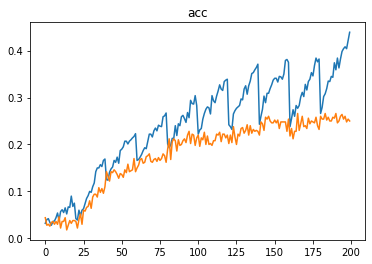

In [17]:
#展示accuracy和loss的變化
logs = history_all

plt.plot(logs['accuracy'])
plt.plot(logs['val_accuracy'])
plt.title('acc')



Text(0.5, 1.0, 'loss')

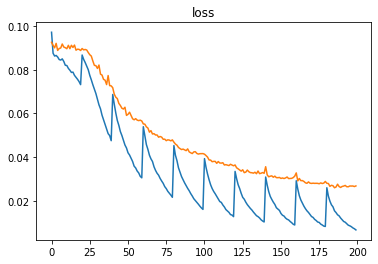

In [18]:
plt.plot(logs['loss'])
plt.plot(logs['val_loss'])
plt.title('loss')